## Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect 
pd.reset_option('all')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/1786183863.py:8: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/1786183863.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


### Import and observe raw data

- author_flair_text: flair is a category functionality that the platform allows for users to categorize their posts
- score: number of upvotes minus number of downvotes


In [2]:
submissions_raw = pd.read_csv("data/raw_submissions.csv")
submissions_raw

,id,created,author,author_flair_text,title,selftext,score,num_comments,link
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...
...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...


## Data Preprocessing

### Remove missing values

In [3]:
def remove_missing_data(raw_df, column):
    '''
    Filters all entries that have [removed] or [deleted] in their body/self 
    text column (as applicable). Also filters NaN values.
    
    Input: 
        - raw_df: Pandas dataframe
        - column: Target column to look for missing values
    
    Returns:
        - Cleaned dataframe
    '''

    print("DataFrame shape before cleaning:", raw_df.shape)

    #Remove rows with values of "[removed]" or "[deleted]" 
    to_filter = ["[removed]", "[deleted]", "\[deleted\]"]
    mask = ~raw_df[column].isin(to_filter)
    filtered_df = raw_df[mask]

    print("DataFrame shape after filtering removed values:", 
                                                 filtered_df.shape)
    
    #Filter NaN
    filtered_df = filtered_df.dropna(subset=[column])
    print("DataFrame shape after filtering NaN values:", filtered_df.shape)

    return filtered_df

In this subreddit, the rules are to put informative titles, so the important information is moslty there. Some of them don't have body text and still contain meaningful content on the title. Therefore, the missing data cleaning needs to be done on the title.

In [4]:
submissions_filtered1 = remove_missing_data(submissions_raw, "title")
submissions_filtered1

DataFrame shape before cleaning: (751027, 9)
DataFrame shape after filtering removed values: (751027, 9)
DataFrame shape after filtering NaN values: (751023, 9)


,id,created,author,author_flair_text,title,selftext,score,num_comments,link
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...
...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...


### Clean text

In [5]:
#https://www.w3schools.com/python/ref_string_translate.asp
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

def clean_text(s):
    '''
    Cleans text
    
        Inputs:
            - s (string)
            
        Returns:
            - cleaned string
    '''

    #Remove links
    text = re.sub(r'http\S+|www\S+', '', s)

    #Removes punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    #Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Remove line breaks
    text = text.replace('\n', ' ').replace('\r', ' ')

    #Lowercase
    text = text.lower()

    #Remove unnecesary whitespace
    return text.strip()

#Apply function to title
submissions_filtered1["cleaned_title"] = submissions_filtered1["title"].apply(lambda x: clean_text(x))

#Apply function to selftext with try/except logic because they could be empty (the poster only wrote in the title)
try:    
    submissions_filtered1["cleaned_bodytext"] = submissions_filtered1["selftext"].apply(lambda x: clean_text(x))
except:
    submissions_filtered1["cleaned_bodytext"] = ""  


### Concatenate title and body text

In [6]:
# Concatenating title and body columns while handling NaN values
submissions_filtered1['title+bodytext'] = submissions_filtered1['cleaned_title']\
        .fillna('') + " " + submissions_filtered1['cleaned_bodytext'].fillna('')

In [7]:
submissions_filtered1

,id,created,author,author_flair_text,title,selftext,score,num_comments,link,cleaned_title,cleaned_bodytext,title+bodytext
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...,tips for being successful in the workplace as ...,,tips for being successful in the workplace as ...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...,if you are using google chrome start typing th...,,if you are using google chrome start typing th...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...,when applying eyedrops dont drop them inside t...,,when applying eyedrops dont drop them inside t...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...,here is how you eat a chicken wing,,here is how you eat a chicken wing
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...,use gmail as a todo list,,use gmail as a todo list
...,...,...,...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...,lpt use a fitted sheet to transport inflated b...,,lpt use a fitted sheet to transport inflated b...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,,lptplease learn from a ton of terrible mistake...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpif you have a dog please please please get ...,,ltpif you have a dog please please please get ...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpis pet insurance worth it or no,,ltpis pet insurance worth it or no


### Remove duplicates

In [8]:
submissions_filtered2 = submissions_filtered1.drop_duplicates(subset=['title+bodytext'])

print("DataFrame shape before removing duplicates:", submissions_filtered1.shape)
print("DataFrame shape after removing duplicates:", submissions_filtered2.shape)

DataFrame shape before removing duplicates: (751023, 12)
DataFrame shape after removing duplicates: (710941, 12)


### Delete very short texts

In [9]:
#Create column with word count
submissions_filtered2['word_count'] = submissions_filtered2['title+bodytext'].apply(lambda x: len(x.split()))

#Delete very short texts
print("Submissions shape before dropping short texts:", submissions_filtered2.shape)
submissions_filtered3 = submissions_filtered2[submissions_filtered2.word_count >= 10]
print("Submissions shape after dropping short texts:", submissions_filtered3.shape)

Submissions shape before dropping short texts: (710941, 13)
Submissions shape after dropping short texts: (563863, 13)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/1245643967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['word_count'] = submissions_filtered2['title+bodytext'].apply(lambda x: len(x.split()))


### Remove non-english posts

In [10]:
def checks_language(text):
    '''
    Checks if the language of the text is english or not
    
        Inputs:
            - s (string)
            
        Returns:
            - Boolean (True if text is in english)
    '''

    #If there's a problem with the text, simply return False
    try: 
        lang = detect(text)
    except:
        return False 
    
    if lang == "en":
        return True
    return False
    

In [11]:
submissions_filtered3['in_english'] = submissions_filtered3['title'].apply(lambda x: checks_language(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/2771921707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3['in_english'] = submissions_filtered3['title'].apply(lambda x: checks_language(x))


Save to csv to manually check if the language detection is correct

In [15]:
not_english = submissions_filtered3[submissions_filtered3.in_english == False][["title", "id"]]
not_english.to_csv("outputs/not_english.csv")

The output reveals many false positives (English posts misclassified as non-English). Despite this, it proves beneficial in filtering out spam and posts in other languages. Deleting these posts entirely would involve a trade-off, removing some valuable data along with the unwanted content. Given the dataset's size, losing some data might not be too bad. Before deciding, we should also assess the performance of posts classified as English.

In [16]:
english = submissions_filtered3[submissions_filtered3.in_english][["title+bodytext", "id"]]
english.to_csv("outputs/english.csv")

submissions_filtered4 = submissions_filtered3[submissions_filtered3.in_english]

print("Submissions shape before dropping non-english posts:", submissions_filtered3.shape)
print("Submissions shape after dropping non-english posts:", submissions_filtered4.shape)

Submissions shape before dropping non-english posts: (563863, 14)
Submissions shape after dropping non-english posts: (561963, 14)


It is impossible to manually check all the english classified data, but by skimming we didn't see anything non-english. Therefore, we'll remove the non-english classified and continue with the reduced data.

### Sentiment analysis - part of preprocessing because at this stage it is only to use it as a helper for identifying spam/odd posts (that could have very high values of positivity/negativiy)

In this part, sentiment analysis will be done to observe outlier values that could be signs of spam

In [17]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyzeSentiment(text):
    # Get sentiment scores (positive, neutral, negative, compound)
    score = sid.polarity_scores(text)
    return score

#Apply function to the dataset
submissions_filtered4['vader_score'] = submissions_filtered4['title+bodytext'].apply(analyzeSentiment)
#Divide result into the 4 categories
submissions_filtered4[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = submissions_filtered4['vader_score'].apply(pd.Series)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/1291680690.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered4['vader_score'] = submissions_filtered4['title+bodytext'].apply(analyzeSentiment)
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/1291680690.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered4[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = submissions_filtered4['vader_score'].apply(pd.Series)
/var/folders/5q/

Check distributions of emotional scores

In [18]:
submissions_filtered4['vader_neg'].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

0.00    0.000
0.10    0.000
0.25    0.000
0.50    0.000
0.75    0.104
0.90    0.181
1.00    0.752
Name: vader_neg, dtype: float64

In [19]:
submissions_filtered4['vader_pos'].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

0.00    0.000
0.10    0.000
0.25    0.000
0.50    0.073
0.75    0.161
0.90    0.243
1.00    0.827
Name: vader_pos, dtype: float64

Sort by values to see if there's any odd submission. Look at the first 50 for both positive and negative emotion values

In [20]:
with pd.option_context('display.max_colwidth', None):
    display(submissions_filtered4.sort_values(by='vader_pos', ascending=False)[["vader_pos","title+bodytext", "id"]].head(50))

,vader_pos,title+bodytext,id
216304,0.827,wishing you all a festive merry joyous and loving holiday season,5fwejr
585151,0.785,win win win 200 amazon gift card please click the below,l5z65a
80186,0.764,romance and love love relationships handle with care and love compatibility,2lu2ex
586379,0.735,free free free 200 amazon gift card dont miss the chance,la7s9x
85808,0.730,thoughts of perfection an easy guide to happiness and success free amazon book,2pcfpk
506549,0.729,love yourself 7 habits for life success best gym inspirational video vibrant angle,gf3zr2
485779,0.727,7 natural beauty treatments womens day 2020 naturally beauty care,fai1zb
93153,0.726,awesome moneymaking opportunity join now and get 2 signup bonus for free,2u02lr
56425,0.725,lpt for a healthy relationship treat your so like your best friend,1ye5l5
415013,0.721,please help me help others any suggestions help thank you,b6yf61


In [21]:
with pd.option_context('display.max_colwidth', None):
    display(submissions_filtered4.sort_values(by='vader_neg', ascending=False)[["vader_neg","title+bodytext", "id"]].head(50))

,vader_neg,title+bodytext,id
596500,0.752,a dumb person cant play smart but a smart person can play dumb,m81wao
234604,0.732,suffer the pain of discipline or suffer the pain of regret,5qtjhc
592663,0.725,learn to differentiate bullies by haters with jealous enviers haters mentally hate jealous physically hates,ltypn2
503219,0.725,if youre sad pissed annoyed angry do a press up,g91d0s
475018,0.715,lpt scream i have aids stop when getting raped to scare the rapist,enfkmg
61582,0.703,lpt killing relationships violence incites retaliatory violence lets stop violence and practice prudence,26cw0u
234606,0.701,ltp suffer the pain of discipline or suffer the pain of regret,5qtksi
472223,0.699,lpt will i be fired or suffer serious reputational damage,eiba60
503220,0.688,lpt if youre sad pissed annoyed angry do a press up,g91ds0
265722,0.678,rotten eggs negative people can be very difficult and depressing,6a4rtx


Store ids of odd posts in a list to remove

In [22]:
irrelevant_pos = ["l5z65a", "la7s9x", "5k9ysy", "5sqdl6", "cvicz2", "2u02lr", "5k9ysy", "3dt25b", "8uwjqj", "5u0klm", "5jhedo", "2nhjwh", 
              "5tbrpo", "8dczqj", "2h0zym", "pyn07p", "57f63p", "5qx2vt"]

irrelevant_neg = ["8exxzv", "o2u5yl", "37j69u", "2by04x", "37j69u"]

to_remove = irrelevant_pos + irrelevant_neg

Function to remove rows with the given values

In [23]:
def filters_df(input_df, column, to_remove):
    '''
    Filters DataFrame based on given values

    Input:
        - input_df
        - column: column to search given values
        - to_remove (list): values to remove

    Output: 
        Filtered df
    '''

    mask = ~input_df[column].isin(to_remove)
    filtered_df = input_df[mask]

    #Check for deleted rows

    num_rows_before = input_df.shape[0]
    num_rows_after = filtered_df.shape[0]

    print("{} rows deleted. {} rows left".format((num_rows_before - num_rows_after), num_rows_after) )
    
    return filtered_df

#Apply function to data
cleaned_submissions = filters_df(submissions_filtered4, "id", to_remove)

20 rows deleted. 561943 rows left


### Get year and month data

In [24]:
#Create function to extract year and month of publication
def extract_time(date_string):
    '''
    Extracts year and month of publication from the "created column
    
    Input:
        - date_string: date and hour of publication
        
    Returns:
        (tuple): year and date of publication'''
    date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")

    return date_object.year, date_object.month

#Apply function to the dataframe to create year and month columns
cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\
                                           (lambda x: pd.Series(extract_time(x)))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/634848451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/634848451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\


## Exploratory Data Analysis (cleaned data)

### Average lenght of texts

Average number of words: 23.558295058395604


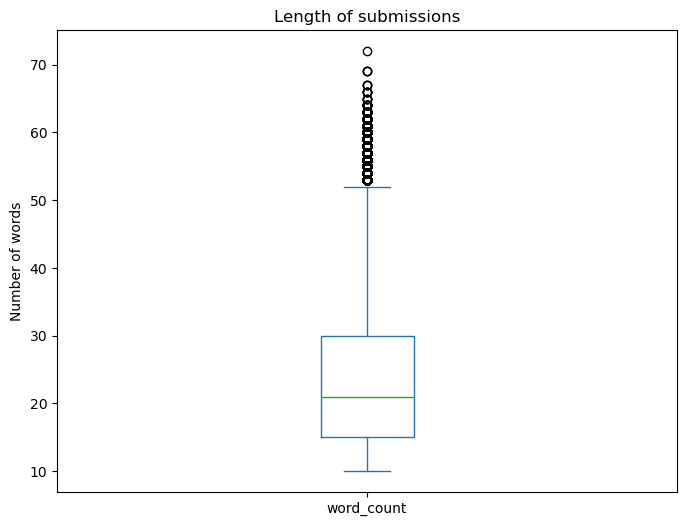

In [25]:
# Average submissions
average_length_submissions = cleaned_submissions['word_count'].mean()
print(f"Average number of words: {average_length_submissions}")

# Create a boxplot of the word counts
plt.figure(figsize=(8, 6))
cleaned_submissions["word_count"].plot(kind='box')
plt.title('Length of submissions')
plt.ylabel('Number of words')
plt.show()

### Observe distribution of volume of publications throughout the years

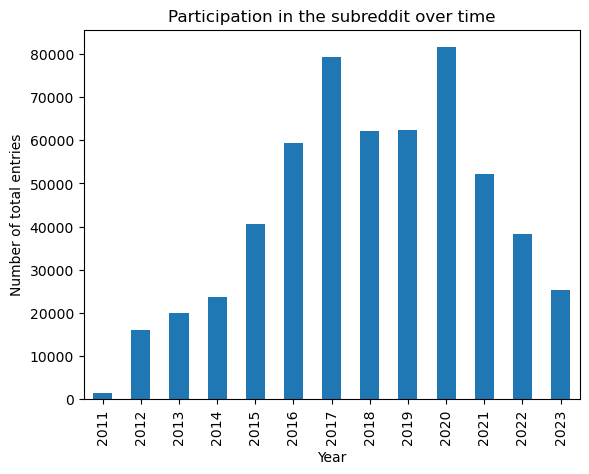

In [26]:
year_counts = cleaned_submissions['year'].value_counts().sort_index()

year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of total entries')
plt.title('Participation in the subreddit over time')
plt.show()

### Observe number of participants in the forum

In [27]:
authors = cleaned_submissions["author"]
print("{} unique authors".format(len(set(authors))))


238880 unique authors


## Export final df

In [28]:
cleaned_submissions.shape

(561943, 21)

In [29]:
cleaned_submissions

,id,created,author,author_flair_text,title,selftext,score,num_comments,link,cleaned_title,...,title+bodytext,word_count,in_english,vader_score,vader_neg,vader_neu,vader_pos,vader_compound,year,month
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...,tips for being successful in the workplace as ...,...,tips for being successful in the workplace as ...,14,True,"{'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...",0.000,0.670,0.330,0.7096,2011,2
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...,if you are using google chrome start typing th...,...,if you are using google chrome start typing th...,43,True,"{'neg': 0.0, 'neu': 0.969, 'pos': 0.031, 'comp...",0.000,0.969,0.031,0.0772,2011,2
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...,when applying eyedrops dont drop them inside t...,...,when applying eyedrops dont drop them inside t...,17,True,"{'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp...",0.000,0.898,0.102,0.2057,2011,2
6,fros1,2011-02-24 02:50,u/someprimetime,NaN,Beer before liquor -- never been sicker; Liquo...,If you are going to mix and match alcoholic dr...,0,6,https://www.reddit.com/r/LifeProTips/comments/...,beer before liquor never been sicker liquor b...,...,beer before liquor never been sicker liquor b...,13,True,"{'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...",0.000,0.822,0.178,0.3818,2011,2
7,fromj,2011-02-24 02:39,u/someprimetime,NaN,"When your significant other isn't around, take...","Shoes, shirts, pants, dresses, etc. This will ...",69,4,https://www.reddit.com/r/LifeProTips/comments/...,when your significant other isnt around take m...,...,when your significant other isnt around take m...,16,True,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.000,0.893,0.107,0.2023,2011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751020,18vj9zl,2023-12-31 16:55,u/ThatOneDudeWithAName,NaN,LPT Request: What are some of your favorite ho...,With the new year rolling around I want to sta...,34,24,https://www.reddit.com/r/LifeProTips/comments/...,lpt request what are some of your favorite hom...,...,lpt request what are some of your favorite hom...,14,True,"{'neg': 0.091, 'neu': 0.727, 'pos': 0.182, 'co...",0.091,0.727,0.182,0.3612,2023,12
751021,18vk01r,2023-12-31 17:34,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,...,lptplease learn from a ton of terrible mistake...,15,True,"{'neg': 0.318, 'neu': 0.682, 'pos': 0.0, 'comp...",0.318,0.682,0.000,-0.6808,2023,12
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,...,lptplease learn from a ton of terrible mistake...,27,True,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",0.189,0.811,0.000,-0.6808,2023,12
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpif you have a dog please please please get ...,...,ltpif you have a dog please please please get ...,11,True,"{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'comp...",0.000,0.504,0.496,0.7096,2023,12


Saving the original title and self text columns creates some issues with parsing when saving the CSV. For that reason, we'll drop them

In [30]:
final_df = cleaned_submissions.drop(["title", "selftext"], axis=1, inplace= False)

In [31]:
final_df.to_csv("data/cleaned_submissions.csv")

Ensure correct parsing

In [32]:
saved_csv = pd.read_csv("data/cleaned_submissions.csv")

print(final_df.shape)
print(saved_csv.shape)

(561943, 19)
(561943, 20)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_8056/3494866926.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  saved_csv = pd.read_csv("data/cleaned_submissions.csv")
